In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.svm import SVC
import statsmodels.api as sm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [114]:
import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [115]:
data = pd.read_csv('SP Raw Data (copy).csv')

In [116]:
#Replace Empty Precipitation Values with Zeros
data['snow'] = data['snow'].fillna(0)
data['prcp'] = data['prcp'].fillna(0)
data['tsun'] = data['tsun'].fillna(0)

#Replace Empty Wind Gusts with Prevailing Wind Speed
data['wpgt'] = np.where(data['wpgt'].isnull(), data['wspd'], data['wpgt'])

#Prep Empty Weather Data for Deletion
data['temp'] = data['temp'].fillna('Drop')
data['dwpt'] = data['dwpt'].fillna('Drop')
data['rhum'] = data['rhum'].fillna('Drop')
data['wspd'] = data['wspd'].fillna('Drop')
data['pres'] = data['pres'].fillna('Drop')

#Convert Weather Condition Code
data['Condition'] = np.where((data['coco'] != range(1,5)), 1, 0) #1 is adverse, 0 is fair
data.drop(['wdir','coco'], axis=1, inplace=True)

In [117]:
#Remove Lines without Pertinent Weather Data
drop_condition1 = (data['temp'] == 'Drop') 
drop_condition2 = (data['rhum'] == 'Drop')
drop_condition3 = (data['wspd'] == 'Drop')
drop_condition4 = (data['pres'] == 'Drop')
drop_condition5 = (data['dwpt'] == 'Drop')

match_data = data.loc[~(drop_condition1|drop_condition2|drop_condition3|drop_condition4|drop_condition5)]

In [118]:
match_data['Int:Temp*Hum'] = match_data['temp']*match_data['rhum']
match_data['Int:Prec*Wind'] = (match_data['prcp']+1)*match_data['wspd']
match_data['Int:Gust*Wind'] = np.abs(match_data['wpgt']-match_data['wspd'])*match_data['wspd']

In [119]:
#Convert Categorical Variables 
def rain_cat(rain):
    if rain==0:
        return 'None'
    elif 0 < rain <= 2.5:
        return 'Light'
    elif 2.5 < rain <= 4:
        return 'Mod'
    elif rain > 4:
        return 'Heavy'
match_data['prcp'] = match_data['prcp'].apply(rain_cat)

def snow_cat(snow):
    if snow==0:
        return 'None'
    elif 0 < snow <= 1:
        return 'Light'
    elif 1 < snow <= 2.5:
        return 'Mod'
    elif snow > 2.5:
        return 'Heavy'
match_data['snow'] = match_data['snow'].apply(snow_cat)

snow_cat_df = pd.get_dummies(match_data['snow'], prefix = 'snow')
rain_cat_df = pd.get_dummies(match_data['prcp'], prefix = 'prcp')

match_data = pd.concat([match_data, rain_cat_df, snow_cat_df], axis=1)
match_data.drop(['snow', 'prcp'], axis=1, inplace=True)

In [120]:
home = match_data.groupby('Home Team').sum()[['Home Points', 'Game Played']].rename(columns={'Game Played':'Home Games'})
away = match_data.groupby('Away Team').sum()[['Away Points', 'Game Played']]

points = pd.concat([home, away], axis=1)
points = points.fillna(0)
points['Total Points'] = points['Home Points'] + points['Away Points']
points['Total Games'] = points['Home Games'] + points['Game Played']
points['PPG'] = points['Total Points'] / points['Total Games']

team_dict = points['PPG'].to_dict()

In [121]:
match_data['Home Strength'] = match_data['Home Team']
match_data = match_data.replace({'Home Strength': team_dict})

match_data['Away Strength'] = match_data['Away Team']
match_data = match_data.replace({'Away Strength': team_dict})

In [122]:
expected_cond1 = match_data['Home Strength'] > match_data['Away Strength']
expected_cond2 = match_data['Result'] == 'Home'
expected_cond3 = match_data['Home Strength'] < match_data['Away Strength']
expected_cond4 = match_data['Result'] == 'Away'
match_data['Expected Result'] = np.where((expected_cond1 & expected_cond2) | (expected_cond3 & expected_cond4), 'Expected', 'Upset')

match_data['HFA'] = np.where(match_data['Result']=='Home', 1, 0)

In [123]:
a = match_data.groupby(by='League')['Away Team'].nunique()
b = match_data.groupby(by='League').sum()['Game Played']
pd.DataFrame(pd.concat([a,b],axis=1))

,Away Team,Game Played
League,,
Bundesliga,25,1434
EPL,28,1721
La Liga,28,1824
Ligue 1,26,1903
Serie A,28,1665


In [124]:
match_data.groupby(['Home Team']).sum().columns[110:124]

Index(['tsun', 'Game Played', 'Home Points', 'Away Points', 'Condition',
       'prcp_Heavy', 'prcp_Light', 'prcp_Mod', 'prcp_None', 'snow_Heavy',
       'snow_None', 'Home Strength', 'Away Strength', 'HFA'],
      dtype='object')

# Define Style of Play

Pre-Processing Team DataFrame

In [125]:
home_stats = match_data.groupby(['Home Team']).sum().iloc[:, np.r_[1:55,121, 111]]
away_stats = match_data.groupby(['Away Team']).sum().iloc[:, np.r_[55:109,122, 111]]

temp = pd.concat([home_stats, away_stats], axis=1)
temp.fillna(0, inplace=True)

In [126]:
team_stats = pd.DataFrame(columns=range(0,56))

for i in range(56):
    team_stats.iloc[:,i] = temp.iloc[:,i]+temp.iloc[:,i+56]

In [127]:
col = ['Goals For','Assist','PK For', 'PK Attempted', 'Shots For', 'Shots on Target', 'Yellow Card', 'Red Card', 'Shot Creating Action', 'Goal Creating Action',
      'Penetrating Pass', 'Carries', 'Penetrating Carries', 'Passes Complete', 'Passes Attempted', 'Pass Completion %', 
      'Total Distance Passed', 'Progressive Distance Passed', 'Short Pass Completion %', 'Medium Pass Completion %', 'Long Pass Completion %', 
      'Switch Pass', 'Cross Pass', 'Corners', 'Tackles', 'Tackles Won', '% Dribblers Tackled', 'Total Blocks', 'Shots Blocked', 'Passes Blocked',
       'Defensive Interceptions', 'Defensive Clearance', 'Defensive Eror', 'Touches', 'Take On Attempts', 'Take On Success', 'Take On Success %', 
       'Carries 2', 'Total Distance Carried', 'Miscontrol', 'Dispossessed', 'Fouls', 'Fouls Drawn', 'Offsides', 'PK Won', 'PK Conceded', 'Own Goal', 
       'Recovery', 'Aerial Won', 'Aerial Lost', 'Aerial Won %', 'Shots on Target Against', 'Goals Against', 'Saves', 'Points','Games Played']

team_stats.columns = col

Normalize by Games Played, Standardize Stats

In [128]:
#Normalize by Number of Games Played
for i in team_stats.columns:
    team_stats[i] = team_stats[i] / team_stats['Games Played']

In [129]:
team_stats = team_stats.drop(['Points', 'Games Played'], axis=1)
team_names = team_stats.index.to_list()
col_names = team_stats.columns

In [130]:
scaler = MinMaxScaler()
team_stats_scaled = pd.DataFrame(scaler.fit_transform(team_stats), index=team_names, columns = col_names)

Define Style of Play Axes

In [131]:
#Correct for Variables where Lower is Better
team_stats_scaled.iloc[:,[32,39,40,43,45,46, 51, 52]] = -team_stats_scaled.iloc[:,[32,39,40,43,45,46, 51, 52]]

In [132]:
off_col = ['Goals For', 'Shots For', 'Shots on Target', 'Shot Creating Action', 'Goal Creating Action',
          'Penetrating Pass', 'Penetrating Carries', 'Corners', 'Offsides']

def_col = ['Total Blocks', 'Shots Blocked', 'Passes Blocked','Defensive Interceptions', 'Defensive Clearance', 
           'Defensive Eror', 'Own Goal','Recovery', 'Aerial Won', 'Aerial Lost',
           'Shots on Target Against', 'Goals Against', 'Saves']

skill_col = ['Carries', 'Passes Complete', 'Passes Attempted', 'Total Distance Passed', 'Progressive Distance Passed', 'Short Pass Completion %', 
             'Medium Pass Completion %', 'Long Pass Completion %', 'Touches', 'Take On Success','Total Distance Carried', 
             'Miscontrol', 'Dispossessed','Fouls Drawn','PK Won']

force_col = ['Tackles', 'Tackles Won', '% Dribblers Tackled','Yellow Card', 'Red Card','Fouls', 'PK Conceded',]

In [174]:
#Offense-Defense Axis
off_def_axis = pd.DataFrame()
off_def_axis['Offense'] = team_stats_scaled[off_col].sum(axis=1)/len(off_col)
off_def_axis['Defense'] = team_stats_scaled[def_col].sum(axis=1)/len(def_col)

#Skill-Force Axis
skill_force_axis = pd.DataFrame()
skill_force_axis['Skill'] = team_stats_scaled[skill_col].sum(axis=1)/len(skill_col)
skill_force_axis['Strength'] = team_stats_scaled[force_col].sum(axis=1)/len(force_col)

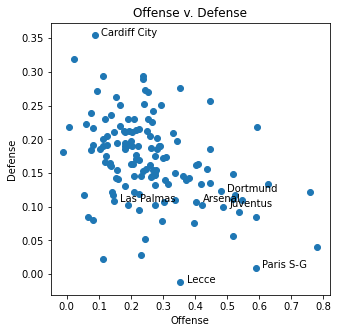

In [134]:
plt.figure(figsize=(5,5))
plt.scatter(off_def_axis['Offense'], -off_def_axis['Defense'])
plot_list = ['Cardiff City','Juventus','Paris S-G','Dortmund','Lecce','Arsenal','Las Palmas']
for i in plot_list:
    plt.annotate(i,(off_def_axis['Offense'][i]+0.02,-off_def_axis['Defense'][i]))
plt.xlabel('Offense')
plt.ylabel('Defense')
plt.title('Offense v. Defense')
plt.show()

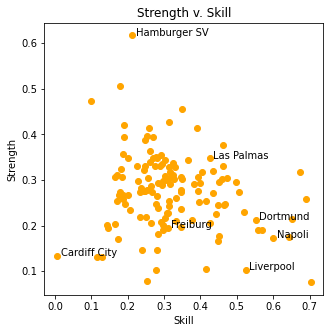

In [135]:
plt.figure(figsize=(5,5))
plt.scatter(skill_force_axis['Skill'],-skill_force_axis['Strength'],color='orange')
plot_list2 = ['Cardiff City','Liverpool','Napoli','Dortmund','Hamburger SV','Freiburg','Las Palmas']
for i in plot_list2:
    plt.annotate(i,(skill_force_axis['Skill'][i]+0.01,-skill_force_axis['Strength'][i]))
plt.xlabel('Skill')
plt.ylabel('Strength')
plt.title('Strength v. Skill')
plt.show()

In [136]:
#Combine Both Axes
style_of_play = pd.DataFrame()
style_of_play['Defense - Offense'] = off_def_axis['Offense'] + off_def_axis['Defense']
style_of_play['Strength - Skill'] = skill_force_axis['Skill'] + skill_force_axis['Strength']

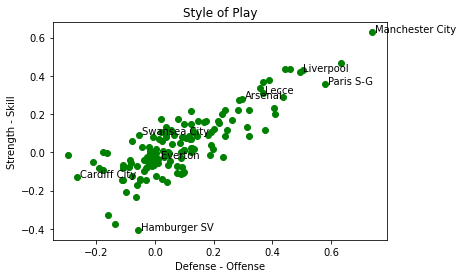

In [137]:
#plt.figure(figsize=(9,8))
plt.scatter(style_of_play['Defense - Offense'],style_of_play['Strength - Skill'],color='green')
plot_list3 = ['Manchester City','Paris S-G','Hamburger SV','Everton','Cardiff City','Liverpool','Arsenal','Swansea City','Lecce']
for i in plot_list3:
    plt.annotate(i,(style_of_play['Defense - Offense'][i]+0.01,style_of_play['Strength - Skill'][i]))
plt.xlabel('Defense - Offense')
plt.ylabel('Strength - Skill')
plt.title('Style of Play')
plt.show()

PCA

In [178]:
#Make 4-D Matrix for Clustering
combined_axes = pd.concat([off_def_axis, skill_force_axis], axis=1)
combined_axes.head(3)

,Offense,Defense,Skill,Strength
Alavés,0.074904,0.184768,0.164585,0.307290
Amiens,0.118446,0.230857,0.169219,0.311454
Angers,0.274919,0.132248,0.302664,0.216823


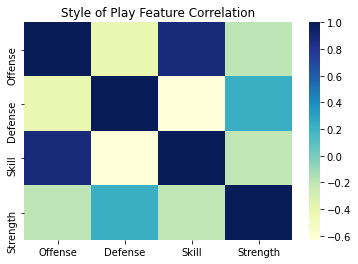

In [179]:
sns.heatmap(combined_axes.corr(), cmap="YlGnBu")
plt.title('Style of Play Feature Correlation')
plt.show()

In [180]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca = pca.fit(combined_axes)
print('Explainated Variance: ', pca.explained_variance_ratio_)
pd.DataFrame([pca.components_[0], pca.components_[1]],columns = combined_axes.columns)

Explainated Variance:  [0.7586816  0.14025805]


,Offense,Defense,Skill,Strength
0,0.741426,-0.183999,0.635405,-0.112661
1,0.147413,0.144216,0.043079,0.977556


In [181]:
pca = pca.fit_transform(combined_axes)

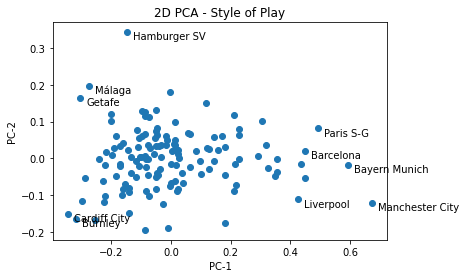

In [182]:
pca_df = pd.DataFrame(pca, index = team_names, columns = ['PC1', 'PC2'])
plt.scatter(data=pca_df, x='PC1', y='PC2')
plot_list = ['Manchester City','Bayern Munich','Cardiff City','Burnley','Barcelona','Paris S-G','Hamburger SV', 'Málaga', 'Liverpool', 'Getafe']
for i in plot_list:
    plt.annotate(i,(pca_df['PC1'][i]+0.02, pca_df['PC2'][i]-0.02))
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('2D PCA - Style of Play')
plt.show()

In [183]:
combined_axes.sort_values(by='Offense', ascending=False).head(2)

,Offense,Defense,Skill,Strength
Manchester City,0.779939,0.039931,0.702652,0.075062
Bayern Munich,0.757806,0.122517,0.642485,0.175610


In [188]:
combined_axes.sort_values(by='Defense', ascending=False).head(3)

,Offense,Defense,Skill,Strength
Cardiff City,0.087679,0.354229,0.005241,0.133937
Burnley,0.021362,0.319242,0.116714,0.131094
Hamburger SV,0.236706,0.294545,0.212029,0.617284


In [185]:
combined_axes.sort_values(by='Skill', ascending=False).head(3)

,Offense,Defense,Skill,Strength
Manchester City,0.779939,0.039931,0.702652,0.075062
Barcelona,0.517929,0.057036,0.691179,0.258182
Paris S-G,0.589568,0.009203,0.673812,0.317948


In [189]:
combined_axes.sort_values(by='Strength', ascending=False).head(2)

,Offense,Defense,Skill,Strength
Hamburger SV,0.236706,0.294545,0.212029,0.617284
Málaga,0.060608,0.222402,0.179194,0.506559


# Clustering

In [140]:
summary = pd.DataFrame(index = team_names)

K-Means

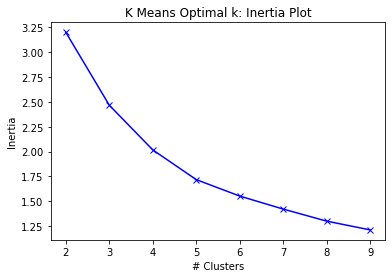

In [141]:
inertia = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=7).fit(combined_axes)
    kmeanModel.fit(combined_axes)
    inertia.append(kmeanModel.inertia_)
    
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Inertia')
plt.title('K Means Optimal k: Inertia Plot')
plt.show()

In [142]:
kmeans = KMeans(n_clusters=5, random_state=7)
kmeans.fit(combined_axes)
summary['KM Cluster'] = kmeans.labels_

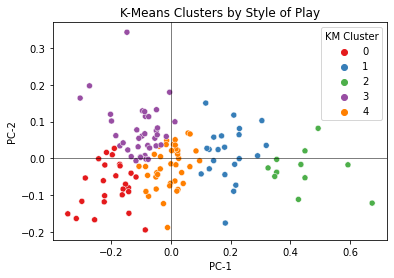

In [187]:
sns.scatterplot(data=pca_df, x='PC1', y='PC2',palette='Set1',hue=summary['KM Cluster'])
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.axvline(x=0,color='black',linewidth=0.5)
plt.axhline(y=0,color='black',linewidth=0.5)
plt.legend(title='KM Cluster')
plt.title('K-Means Clusters by Style of Play')
plt.show()

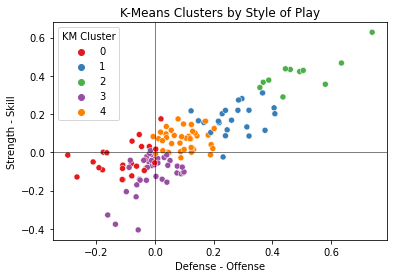

In [143]:
sns.scatterplot(data=style_of_play, x='Defense - Offense', y='Strength - Skill',palette='Set1',hue=summary['KM Cluster'])
plt.xlabel('Defense - Offense')
plt.ylabel('Strength - Skill')
plt.axvline(x=0,color='black',linewidth=0.5)
plt.axhline(y=0,color='black',linewidth=0.5)
plt.legend(title='KM Cluster')
plt.title('K-Means Clusters by Style of Play')
plt.show()

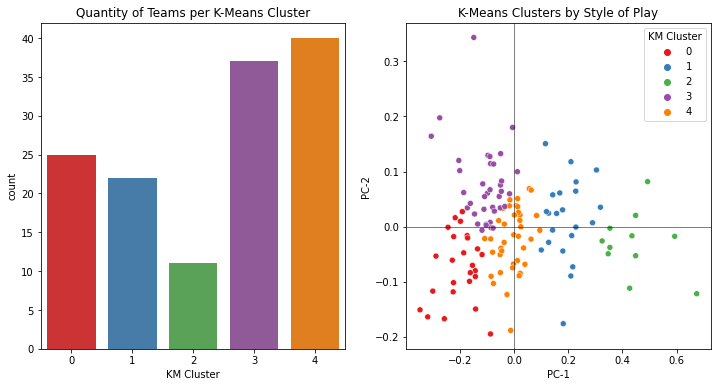

In [193]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(data=summary, x='KM Cluster', palette='Set1')
plt.title('Quantity of Teams per K-Means Cluster')
plt.subplot(1,2,2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2',palette='Set1',hue=summary['KM Cluster'])
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.axvline(x=0,color='black',linewidth=0.5)
plt.axhline(y=0,color='black',linewidth=0.5)
plt.legend(title='KM Cluster')
plt.title('K-Means Clusters by Style of Play')
plt.show()

GMM

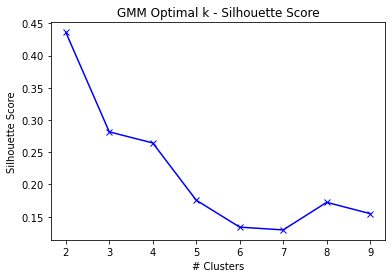

In [145]:
S = []
for i in range(2,10):
    gmm = GaussianMixture(n_components=i, random_state=7)
    gmm.fit(combined_axes)
    sil_score = silhouette_score(combined_axes, gmm.predict(combined_axes))
    S.append(sil_score)

plt.plot(range(2,10), S, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Score')
plt.title('GMM Optimal k - Silhouette Score')
plt.show()

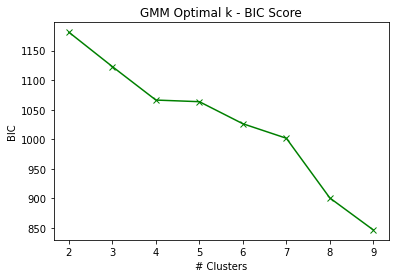

In [146]:
bic_scores=[]
for i in range(2,10):
    gmm_bic = GaussianMixture(n_components = i, random_state=4)
    gmm_bic.fit(combined_axes)
    bic_scores.append(-gmm_bic.bic(combined_axes))

plt.plot(range(2,10), bic_scores, 'bx-', color='green')
plt.xlabel('# Clusters')
plt.ylabel('BIC')
plt.title('GMM Optimal k - BIC Score')
plt.show()

In [147]:
gmm = GaussianMixture(n_components = 4, random_state=4)
gmm.fit(combined_axes)
summary['GMM Cluster'] = gmm.predict(combined_axes)

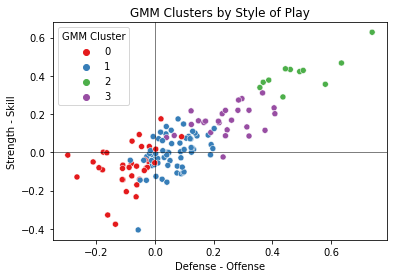

In [190]:
sns.scatterplot(data=style_of_play, x='Defense - Offense', y='Strength - Skill',palette='Set1',hue=summary['GMM Cluster'])
plt.xlabel('Defense - Offense')
plt.ylabel('Strength - Skill')
plt.axvline(x=0,color='black',linewidth=0.5)
plt.axhline(y=0,color='black',linewidth=0.5)
plt.legend(title='GMM Cluster')
plt.title('GMM Clusters by Style of Play')
plt.show()

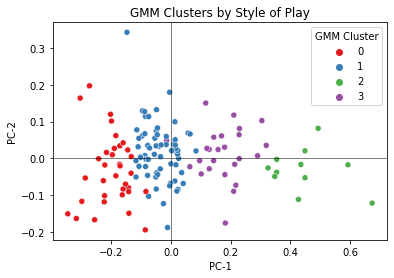

In [191]:
sns.scatterplot(data=pca_df, x='PC1', y='PC2', palette='Set1',hue=summary['GMM Cluster'])
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.axvline(x=0,color='black',linewidth=0.5)
plt.axhline(y=0,color='black',linewidth=0.5)
plt.legend(title='GMM Cluster')
plt.title('GMM Clusters by Style of Play')
plt.show()

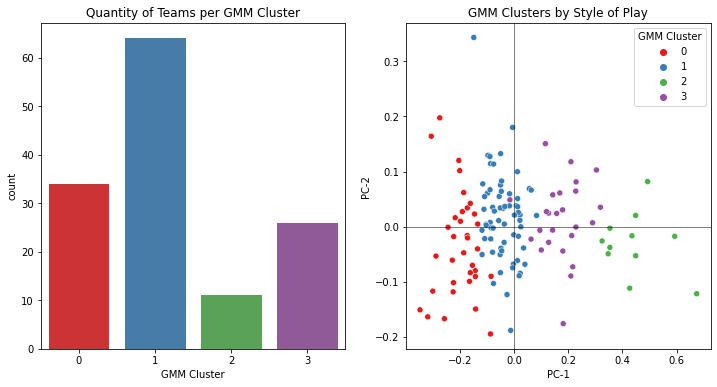

In [192]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(data=summary, x='GMM Cluster', palette='Set1')
plt.title('Quantity of Teams per GMM Cluster')
plt.subplot(1,2,2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', palette='Set1',hue=summary['GMM Cluster'])
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.axvline(x=0,color='black',linewidth=0.5)
plt.axhline(y=0,color='black',linewidth=0.5)
plt.legend(title='GMM Cluster')
plt.title('GMM Clusters by Style of Play')
plt.show()

Model Comparison

In [150]:
kmeans_sil = silhouette_score(combined_axes, summary['KM Cluster'], random_state=10)
gmm_sil = silhouette_score(combined_axes, summary['GMM Cluster'], random_state=5)
print('Silhouette Score Comparison')
print('K-Means Score: ', kmeans_sil)
print('GMM Score: ', gmm_sil)

Silhouette Score Comparison
K-Means Score:  0.24668434915007906
GMM Score:  0.26867349980832284


Cluster Qualities

In [151]:
summary['Count']=1
km_dist = pd.DataFrame(summary.groupby(by='KM Cluster').sum()['Count'])
km_dist['%'] = km_dist['Count']/135
km_dist

,Count,%
KM Cluster,,
0,25,0.185185
1,22,0.162963
2,11,0.081481
3,37,0.274074
4,40,0.296296


In [152]:
cluster_dict = summary['KM Cluster'].to_dict()

In [153]:
match_data['Home Cluster'] = match_data['Home Team']
match_data = match_data.replace({'Home Cluster': cluster_dict})

match_data['Away Cluster'] = match_data['Away Team']
match_data = match_data.replace({'Away Cluster': cluster_dict})

In [154]:
home_cluster_df = pd.get_dummies(match_data['Home Cluster'], prefix = 'Home')
away_cluster_df = pd.get_dummies(match_data['Away Cluster'], prefix = 'Away')

match_data = pd.concat([match_data, home_cluster_df, away_cluster_df], axis=1)

In [155]:
pd.DataFrame(match_data.groupby(by='Home Cluster')['Expected Result'].value_counts())

Expected Result
Home Cluster Expected Result                 
0            Upset                        440
             Expected                     420
1            Expected                    1061
             Upset                        805
2            Expected                     734
             Upset                        287
3            Upset                       1150
             Expected                    1019
4            Upset                       1392
             Expected                    1239

In [156]:
pd.DataFrame(match_data.groupby(by='Away Cluster')['Expected Result'].value_counts())

Expected Result
Away Cluster Expected Result                 
0            Expected                     589
             Upset                        416
1            Upset                        907
             Expected                     880
2            Expected                     560
             Upset                        379
3            Expected                    1108
             Upset                       1056
4            Expected                    1336
             Upset                       1316

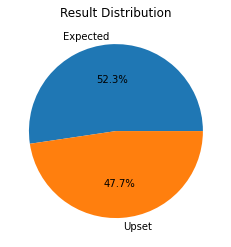

In [157]:
pie = match_data['Expected Result'].value_counts()
label = ['Expected', 'Upset']
plt.pie(pie, labels=label, autopct='%1.1f%%')
plt.title('Result Distribution')
plt.show()

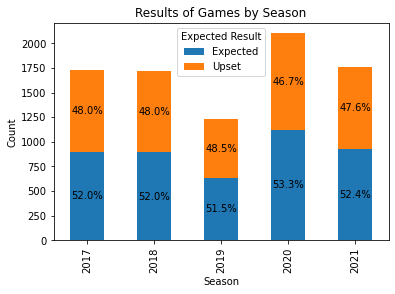

In [158]:
# Code here for the bar plot by season
counts = match_data.groupby(by=['Season', 'Expected Result']).size().unstack(fill_value=0)
percentages = counts.apply(lambda x: x/x.sum(), axis=1) * 100

ax = counts.plot(kind='bar', stacked=True)
ax.set_xlabel('Season')
ax.set_ylabel('Count')
ax.set_title('Results of Games by Season')
for i, row in enumerate(percentages.iterrows()):
    season, data = row
    total = data.sum()
    y_pos = counts.iloc[i].cumsum() - counts.iloc[i] / 2
    for j, val in enumerate(data):
        if val > 0:
            ax.text(i, y_pos[j], f'{val:.1f}%', ha='center', va='center')
plt.show()

# Classification

In [159]:
match_data['Expected Result #'] = match_data.loc[:,'Expected Result']
match_data = match_data.replace({'Expected Result #': {'Expected':0,'Upset':1}})

In [160]:
class_cols = ['temp', 'dwpt', 'rhum', 'wspd', 'wpgt', 'pres', 'tsun', 'Condition', 'Int:Temp*Hum', 'Int:Prec*Wind',
       'Int:Gust*Wind', 'prcp_Heavy', 'prcp_Light', 'prcp_Mod', 'prcp_None',
       'snow_Heavy', 'snow_None', 'Home_0', 'Home_1','Home_2', 'Home_3', 'Home_4', 'Away_0', 'Away_1', 'Away_2', 'Away_3', 'HFA']

In [161]:
X_result = match_data[class_cols]
y_result = match_data['Expected Result #']

scaler = StandardScaler()
scaler.fit_transform(X_result)

x_train, x_test, y_train, y_test = train_test_split(X_result, y_result, test_size = 0.2, random_state = 4)

SVM

In [162]:
kernel = ['linear', 'rbf', 'poly']
Cs = [0.1,1,10,100]
svm_results = pd.DataFrame(columns=['Kernel', 'C', 'Accuracy'])

for kernel in kernel: 
    for C in [0.1,1,10,100]:
        svm = SVC(kernel=kernel, C=C, random_state=4)
        svm.fit(x_train, y_train)
        pred_svm = svm.predict(x_test)
        accuracy_svm = accuracy_score(y_test, pred_svm)
        temp = pd.DataFrame([[kernel, C, accuracy_svm]],columns=['Kernel', 'C', 'Accuracy'])
        svm_results = svm_results.append(temp, ignore_index=True)
            
svm_results.sort_values(by='Accuracy', ascending=False).head(5)

,Kernel,C,Accuracy
0,linear,0.1,0.691228
1,linear,1.0,0.674854
3,linear,100.0,0.661988
2,linear,10.0,0.659649
7,rbf,100.0,0.522222


In [194]:
svm = SVC(kernel = 'linear', C = 0.1, random_state=4)
svm.fit(x_train, y_train)

pred_svm = svm.predict(x_test)
accuracy_svm = accuracy_score(y_test, pred_svm)
print(f'Accuracy: {accuracy_svm:.2f}')

Accuracy: 0.69


Decision Tree

In [164]:
max_features = ['sqrt', 'log2']
dt_results = pd.DataFrame(columns=['Max Features', 'Depth', 'Accuracy'])

for max_features in max_features:
    for depth in range(3,8): 
        dt = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
        dt.fit(x_train, y_train)
        pred_dt = dt.predict(x_test)
        accuracy_dt = accuracy_score(y_test, pred_dt)
        temp = pd.DataFrame([[max_features, depth, accuracy_dt]],columns=['Max Features', 'Depth', 'Accuracy'])
        dt_results = dt_results.append(temp, ignore_index=True)

dt_results.sort_values(by='Accuracy', ascending=False).head(5)

,Max Features,Depth,Accuracy
2,sqrt,5,0.780117
7,log2,5,0.780117
3,sqrt,6,0.776608
8,log2,6,0.776608
4,sqrt,7,0.765497


In [165]:
dt = tree.DecisionTreeClassifier(max_depth = 5, random_state = 42)
dt = dt.fit(x_train, y_train)

pred_dt = dt.predict(x_test)
accuracy_dt = accuracy_score(y_test, pred_dt)
print(f'Accuracy: {accuracy_dt:.4f}')
print('Max Features: ', dt.max_features_)

Accuracy: 0.7801
Max Features:  27


Random Forest

In [166]:
n_estimators = [10,50,100,150,200,250,300]
min_leaf = [1,5,10,50,100,200,500]
max_feature = ['sqrt', 'log2']
rf_results = pd.DataFrame(columns=['Estimators', 'Min Leaf', 'Max Features', 'Depth', 'Accuracy'])

for n_estimators in n_estimators:
    for min_leaf in [1,5,10,50,100,200,500]:
        for max_features in max_feature:
            for depth in range(3,8):
                rf = RandomForestClassifier(n_estimators = n_estimators, max_depth = depth, min_samples_leaf = min_leaf, max_features = max_features, random_state=4)
                rf.fit(x_train, y_train)
                pred_rf = rf.predict(x_test)
                accuracy_rf = accuracy_score(y_test, pred_rf)
                temp = pd.DataFrame([[n_estimators, min_leaf, max_features, depth, accuracy_rf]], columns=['Estimators', 'Min Leaf', 'Max Features', 'Depth','Accuracy'])
                rf_results = rf_results.append(temp, ignore_index=True)

rf_results.sort_values(by='Accuracy', ascending=False).head(5)

,Estimators,Min Leaf,Max Features,Depth,Accuracy
29,10,10,log2,7,0.769591
39,10,50,log2,7,0.760819
99,50,10,log2,7,0.759649
424,300,1,sqrt,7,0.757310
239,150,10,log2,7,0.756140


Logistic Regression

In [167]:
rf = RandomForestClassifier(random_state=4)
rf.fit(x_train, y_train)

pred_rf = rf.predict(x_test)
accuracy_rf = accuracy_score(y_test, pred_rf)
print(f'Accuracy: {accuracy_rf:.3f}')

Accuracy: 0.754


In [168]:
penalty = ['l1', 'l2']
C = [0.1,1,10,100]
lr_results = pd.DataFrame(columns=['Penalty', 'C', 'Accuracy'])

for penalty in penalty:
    for C in [0.1,1,10,100]:
        lr = LogisticRegression(penalty = penalty, C = C, solver='liblinear', random_state=4)
        lr.fit(x_train,y_train)
        pred_lr = lr.predict(x_test)
        accuracy_lr = accuracy_score(y_test, pred_lr)
        temp = pd.DataFrame([[penalty, C, accuracy_lr]], columns=['Penalty', 'C', 'Accuracy'])
        lr_results = lr_results.append(temp, ignore_index=True)

lr_results.sort_values(by='Accuracy', ascending=False).head(5)

,Penalty,C,Accuracy
6,l2,10.0,0.660819
5,l2,1.0,0.659064
7,l2,100.0,0.659064
1,l1,1.0,0.657310
2,l1,10.0,0.656140


Other Performance Measures

In [170]:
def metrics(y_test, pred, model):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc = roc_auc_score(y_test, pred)
    metrics = pd.DataFrame([[accuracy, precision,recall,f1,roc]], index = [str(model)], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'])
    return metrics

In [169]:
lr = LogisticRegression(random_state=4)
lr.fit(x_train,y_train)

pred_lr = lr.predict(x_test)
accuracy_lr = accuracy_score(y_test, pred_lr)
print(f'Accuracy: {accuracy_lr:.3f}')

Accuracy: 0.614


In [195]:
pd.concat([metrics(y_test, pred_svm, svm), metrics(y_test, pred_dt, dt), metrics(y_test, pred_rf, rf), metrics(y_test, pred_lr, lr)])

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
"SVC(C=0.1, kernel='linear', random_state=4)",0.691228,0.677033,0.686893,0.681928,0.691076
"DecisionTreeClassifier(max_depth=5, random_state=42)",0.780117,0.795515,0.731796,0.762326,0.778426
RandomForestClassifier(random_state=4),0.753801,0.740741,0.752427,0.746538,0.753753
LogisticRegression(random_state=4),0.614035,0.597852,0.608010,0.602888,0.613824


Fitting a Decision Tree

In [199]:
dt_2 = tree.DecisionTreeClassifier(max_depth = 8, max_features = 'sqrt', random_state = 42)
dt_2 = dt_2.fit(x_test, y_test)

dotfile = open("dtree2.dot", 'w')
export_graphviz(dt_2, out_file=dotfile, feature_names=X_result.columns, class_names=['Expected Win', 'Upset Win'], filled=True, rounded=True)
dotfile.close()